In [2]:
import hdf5storage
import rat.helpers as helpers
import rat.get_data as get_data
import numpy as np
from bat.helpers_bat import *
from bat.get_data import *


%load_ext autoreload
%autoreload 2


## Loading in the bat data (LFP and positional data)
We first need to load in the LFP data, which in this case is stored in a MATLAB file. We can do this using ```hdf5storage```. The bat's positional data is stored in a different file, but luckily the accessors for this were provided by the Yartsev lab (thanks Kevin Qi!).

In [3]:
# Loading bat LFP data
lfp_mat = hdf5storage.loadmat('./bat/data/ephys/32622_231007_lfp.mat')

# Check the structure of lfp_mat
print("Structure of lfp_mat:", type(lfp_mat['lfp']), lfp_mat['lfp'].shape)


Structure of lfp_mat: <class 'numpy.ndarray'> (1, 2)


In [4]:
data_path = './bat/data' # Replace this
bat_id = '32622'
date =  '231007'

In [5]:
session = FlightRoomSession(data_path, bat_id, date, use_cache = True) # use_cache = True to save time on future loads

Loading Flight Room | 32622 | 231007 from cache...


In [6]:
pos = session.cortex_data.bat_pos
pos.shape # (num_timepoints, XYZ)

(841160, 3)

Since the position data has a lot of NaNs throughout it, we can interpolate across these spans of NaN values to create a cleaner dataset. More on how this affects the data in ```example.ipynb```.

In [7]:
cleaned_pos = np.copy(pos)
# still position on walls are nans (dont interpolate large gaps of nans)
cleaned_pos[:, 0] = interpolate_nans(pos[:, 0])
cleaned_pos[:, 1] = interpolate_nans(pos[:, 1])
cleaned_pos[:, 2] = interpolate_nans(pos[:, 2])
cleaned_pos.shape

(841160, 3)

## Time synchronization
Before we get to the main attraction (the LFP data), we need to ensure our data is synchronized. To do this, we need to extract global timestamps from both the LFP and positional data and make sure they start at the same time.

In [8]:
lfp_timestamps = lfp_mat['global_sample_timestamps_usec'] #global timestamps in microseconds

np.diff(lfp_timestamps.flatten()) #we will see a 400 microsecond difference between each timestamp,
#which means that the sampling rate is 2500 Hz

array([400.00444436, 400.0044446 , 400.00444436, ..., 399.99999905,
       400.        , 400.00000191])

In [9]:
lfp_timestamps.shape

(17222917, 1)

Above, we filtered out the negative timestamps from the position recording relative to the global timestamp start. We simply had to filter out the corresponding samples in position to synchronize. Now we're ready to make timebins from the LFP timestamp data and bin the positional data accordingly.

In [10]:
from scipy.signal import decimate
lfp_timestamps_dec = decimate(lfp_timestamps.flatten(), 100) #decimate from 2500 Hz to 25 Hz (100x decimation)
lfp_timestamps_dec.shape
#lfp_timestamps_dec[0:10]

(172230,)

Now that we downsampled the LFP timestamps, we will lop off negative timestamps to ensure that we have proper "edges" between bins (more on this later).

In [11]:
lfp_indices = lfp_timestamps_dec > 0 # lop off negative timestamps on LFP timestamps; we will use this to refit the LFP data later.
lfp_timestamps_dec = lfp_timestamps_dec[lfp_indices] 
lfp_timestamps_edges = np.insert(lfp_timestamps_dec, 0, 0) # insert 0 at the beginning

lfp_timestamps_edges.shape
lfp_timestamps_edges[0:10]

array([     0.        ,   4514.44262606,  44057.00577409,  83599.56892214,
       123142.1320702 , 162684.69521825, 202227.25836628, 241769.82151429,
       281312.3846624 , 320854.94781046])

We now have our decimated LFP timebins. Inside of ```lfp_timestamps_edges```, we store the *edges* between timebins. We will use this to later to bin the position data; instead of downsampling the data like we did the LFP, we will average out points between edges of the LFP timebins to get synchronized data streams.

In [12]:
pos_timestamps = session.cortex_data.cortex_global_sample_timestamps_sec * 1e6 #converting to microseconds (usec)
valid_indices = pos_timestamps > 0 #we can use this to get rid of negative timestamps on anything position related

pos_timestamps = pos_timestamps[valid_indices] # lop off negative timestamps 
np.diff(pos_timestamps) #we will see an average of a 8333 microsecond difference between each timestamp, meaning that the sampling rate is around 120 Hz

array([8333.33333331, 8333.33333334, 8333.33333334, ..., 8333.33772278,
       8333.33771515, 8333.33771515])

In [13]:
cleaned_pos = cleaned_pos[valid_indices] # lop off the corresponding positions
cleaned_pos.shape

(824435, 3)

In [14]:
# Bin positional data using the provided label_timebins function
binned_pos_x = label_timebins(lfp_timestamps_edges, cleaned_pos[:, 0], pos_timestamps, is_discrete=False)
binned_pos_y = label_timebins(lfp_timestamps_edges, cleaned_pos[:, 1], pos_timestamps, is_discrete=False)
binned_pos_z = label_timebins(lfp_timestamps_edges, cleaned_pos[:, 2], pos_timestamps, is_discrete=False)

# Construct the array according to its columns
binned_pos = np.column_stack((binned_pos_x, binned_pos_y, binned_pos_z))

In [15]:
# Verify the results
print("Binned position shape:", binned_pos.shape)
print("LFP timestamp edges shape:", lfp_timestamps_edges.shape)

print("First few elements of binned_pos:\n", binned_pos[:, :5]) # NaN values at beginning and end are expected; position is not recorded when bat is not visible.

print("First few LFP bins:", lfp_timestamps_edges[:5])

Binned position shape: (170690, 3)
LFP timestamp edges shape: (170691,)
First few elements of binned_pos:
 [[        nan         nan         nan]
 [-1.35497956 -1.70192085  0.01016301]
 [-1.35496366 -1.70190326  0.01020436]
 ...
 [-1.24507387 -1.627617    0.04300965]
 [-1.24505479 -1.62760721  0.0430833 ]
 [        nan         nan         nan]]
First few LFP bins: [     0.           4514.44262606  44057.00577409  83599.56892214
 123142.1320702 ]


Notice above that the LFP timestamp edges have N+1 the shape of the binned position. This makes sense and is expected; `lfp_timestamps_edges` contains the bins (which are stored in groups of two, i.e. the first bin is [0, 4514.4426] and so on) for which the position was binned into.

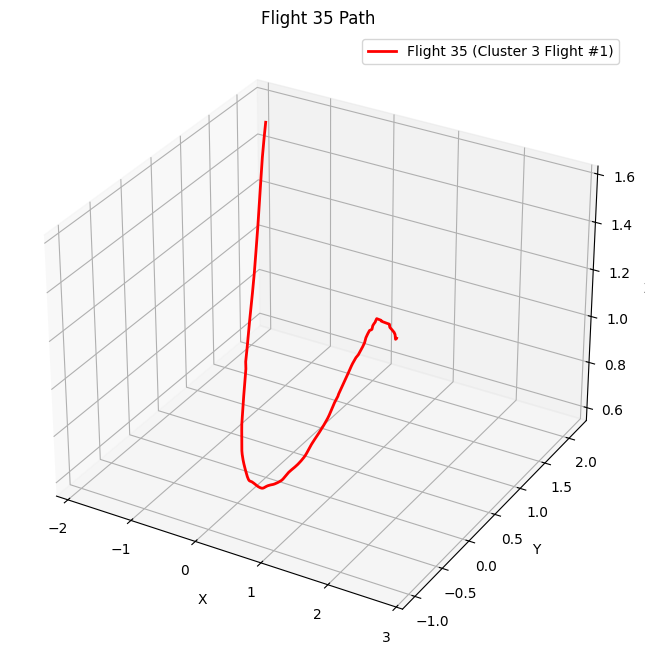

In [16]:
from bat.get_data import get_cluster_labels, get_flight_boolean_array
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.colors as mcolors

clutser_2_labels = get_cluster_labels(session, 2)

# Get boolean array for the 35th flight overall (which might be in cluster 3)
flight_35_bool, _, flight_35_cluster = get_flight_boolean_array(session, 35)

# Create a new figure and 3D axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use the boolean array for indexing or plotting
ax.plot(pos[flight_35_bool, 0], pos[flight_35_bool, 1], pos[flight_35_bool, 2],
        color='red', linewidth=2, label=f'Flight 35 (Cluster 3 Flight #1)')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Flight 35 Path')

# Add legend
ax.legend()

# Show the plot
plt.show()

We are creating labels (timebin_labels) to associate which timebins are related to which flight so we can access them accordingly.

In [17]:
labels = flight_35_bool[valid_indices] # we can also do this by cluster : labels = cluster_2_labels[valid_indices]
labels.shape

(824435,)

In [18]:
timebin_labels = label_timebins(lfp_timestamps_edges, labels, pos_timestamps, is_discrete=True)
timebin_labels.shape

(170690,)

In [19]:
print(len(binned_pos[0]), len(binned_pos[1]), len(timebin_labels))

3 3 170690


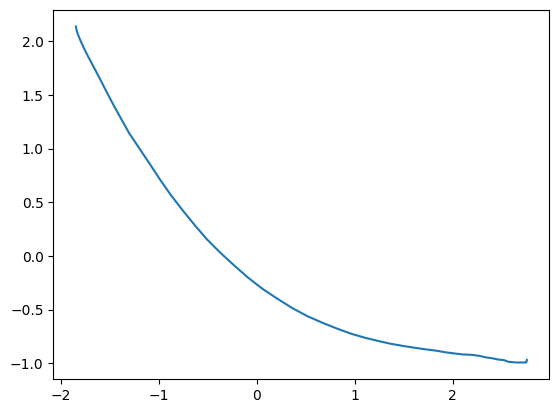

In [20]:
plt.plot(binned_pos[:, 0][:len(timebin_labels)][timebin_labels > 0], 
         binned_pos[:, 1][:len(timebin_labels)][timebin_labels > 0])

Using timebin_labels, we can filter out the binned position data for each flight. This will allow us to organize flight data later.

### Organizing behavioral data
To better organize the binned flight data, we need to construct a flightID array which will contain all the binned positions for each flight, accounting for which feeder (or the perch) was visited for each data point entered in that flight.

In [21]:
from bat.get_data import get_flightID

flightID = get_flightID(session, binned_pos, valid_indices, lfp_timestamps_edges, pos_timestamps, off_samples = 125) #includes the 5 seconds before and after flight

Total clusters: 8
Shape of binned_pos: (170690, 3)
Length of valid_indices: 841160
Length of lfp_timestamps_decimated_bins: 170691
Length of pos_timestamps: 824435
Cluster 2: 34 flights

Processing flight 1
Length of flight_bool: 841160
Sum of flight_bool: 737
Length of labels after valid_indices: 824435
Sum of labels: 737
Length of timebin_labels: 170690
Sum of timebin_labels: 155.0
Shape of flight_pos: (155, 3)
Shape of flight_phases: (155,)
Added flight data with shape: (155, 6)
Unique phase labels: [0. 1. 2.]

Processing flight 2
Length of flight_bool: 841160
Sum of flight_bool: 726
Length of labels after valid_indices: 824435
Sum of labels: 726
Length of timebin_labels: 170690
Sum of timebin_labels: 153.0
Shape of flight_pos: (153, 3)
Shape of flight_phases: (153,)
Added flight data with shape: (153, 6)
Unique phase labels: [0. 1. 2.]

Processing flight 3
Length of flight_bool: 841160
Sum of flight_bool: 735
Length of labels after valid_indices: 824435
Sum of labels: 735
Length of

In [22]:
flightID.shape

(11480, 6)

In [23]:
flightID[:-10]

array([[ 1.        ,  1.        ,  2.43302144,  0.63756902,  1.62228234,
         0.        ],
       [ 1.        ,  1.        ,  2.43182567,  0.63688812,  1.62217812,
         0.        ],
       [ 1.        ,  1.        ,  2.43062991,  0.63620721,  1.6220739 ,
         0.        ],
       ...,
       [78.        ,  0.        , -1.78778248,  2.37162161,  1.7141637 ,
         2.        ],
       [78.        ,  0.        , -1.79510347,  2.3957242 ,  1.71606067,
         2.        ],
       [78.        ,  0.        , -1.80046474,  2.41260205,  1.71747944,
         2.        ]])

## LFP extraction and downsampling

In [24]:
# Extract subarrays and check their structure
lfp_data_1 = lfp_mat['lfp'][0, 0]
lfp_data_2 = lfp_mat['lfp'][0, 1]

print(f"Type of lfp_data_1: {type(lfp_data_1)}, Shape of lfp_data_1: {lfp_data_1.shape}")
print(f"Type of lfp_data_2: {type(lfp_data_2)}, Shape of lfp_data_2: {lfp_data_2.shape}")

n_channels = lfp_data_1.shape[0] #same # of channels for lfp_data_1 and lfp_data_2 (change if not the case)


Type of lfp_data_1: <class 'numpy.ndarray'>, Shape of lfp_data_1: (192, 17222917)
Type of lfp_data_2: <class 'numpy.ndarray'>, Shape of lfp_data_2: (192, 17222917)


We have the raw MATLAB data field stored in `lfp_data_1` and `lfp_data_2`, but in order to actually work with this data, we need to deserialize it into an array we can index. To do this, I've supplied `helpers.py/get_LFP_from_mat`, which will *import and automatically decimate the data*. 

In [25]:
from rat.get_data import get_LFP_from_mat
# bat LFP data sampled at 2500 Hz
lfp_bat_1 = get_LFP_from_mat(lfp_data_1,n_channels,2500,use_cache=True) #in order to change decimation, change fs=25 to desired sampling rate
lfp_bat_2 = get_LFP_from_mat(lfp_data_2,n_channels,2500,use_cache=True)

lfp_bat_combined = np.concatenate((lfp_bat_1, lfp_bat_2), axis=1) # ALREADY DECIMATED TO 25 Hz


In [26]:
print("lfp_bat_1 shape:", lfp_bat_1.shape) # (n_samples, n_channels)
print("lfp_bat_2 shape:", lfp_bat_2.shape) # (n_samples, n_channels)
print("lfp_bat_combined shape:", lfp_bat_combined.shape) # (n_samples, 2*n_channels)

lfp_bat_1 shape: (172230, 192)
lfp_bat_2 shape: (172230, 192)
lfp_bat_combined shape: (172230, 384)


Once LFP is loaded in and downsampled, we can apply a bandpass and Hilbert transform to get our complex-valud LFP!

In [27]:
LFPs = helpers.filter_data(lfp_bat_combined, [4, 12], fs=25, filt_type='band', use_hilbert=True) #bandapss filter between 4 and 12 Hz (theta band)
LFPs.shape

(172230, 384)

In [28]:
LFPs = LFPs[lfp_indices]
LFPs.shape


(170690, 384)

We now have our processed LFP. `LFPs` contains the filtered and transformed (Hilbert transform, so that we can work with complex numbers for our network) LFP data for all of the valid `binned_pos` entries. However, we are mainly interested in the bat flights, which are just a *fraction* of the total of `binned_pos`. To filter out the non-flight entries from the LFP, we will apply a similar filtering method as we did in `get_flightID` with a `get_flightLFP` function:

In [29]:
from bat.get_data import get_flightLFP

tLFP = get_flightLFP(session, LFPs, valid_indices, lfp_timestamps_edges, pos_timestamps, off_samples=125) # Make sure off_samples is the same for flightID and tLFP.

Shape of LFPs: (170690, 384)
Length of valid_indices: 841160
Length of lfp_timestamps_decimated_bins: 170691
Length of pos_timestamps: 824435
Cluster 2: 34 flights

Processing flight 1
Length of flight_bool: 841160
Sum of flight_bool: 737
Length of labels after valid_indices: 824435
Sum of labels: 737
Length of timebin_labels: 170690
Sum of timebin_labels: 155.0
Shape of flight_lfp: (155, 384)
Shape of flight_phases: (155,)
Added flight data with shape: (155, 386)
Unique phase labels: [0. 1. 2.]

Processing flight 2
Length of flight_bool: 841160
Sum of flight_bool: 726
Length of labels after valid_indices: 824435
Sum of labels: 726
Length of timebin_labels: 170690
Sum of timebin_labels: 153.0
Shape of flight_lfp: (153, 384)
Shape of flight_phases: (153,)
Added flight data with shape: (153, 386)
Unique phase labels: [0. 1. 2.]

Processing flight 3
Length of flight_bool: 841160
Sum of flight_bool: 735
Length of labels after valid_indices: 824435
Sum of labels: 735
Length of timebin_label

In [30]:
tLFP.shape

(11480, 386)

/Users/tenboker/Desktop/Code Shtuff/FRITZ/yartsev/venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tenboker/Desktop/Code Shtuff/FRITZ/yartsev/venv/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


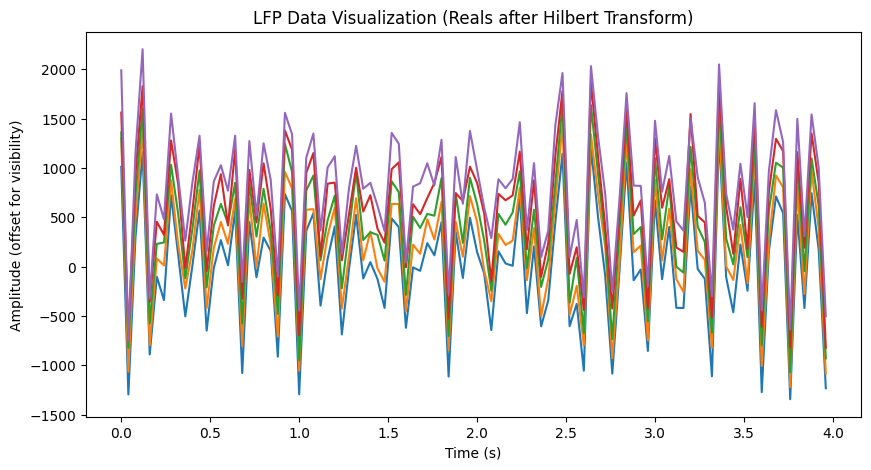

In [31]:
from bat.synchrony import plot_raw_lfp

# Example usage
plot_raw_lfp(LFPs, n_channels=5, start_time=0, end_time=100)


## Testing synchrony

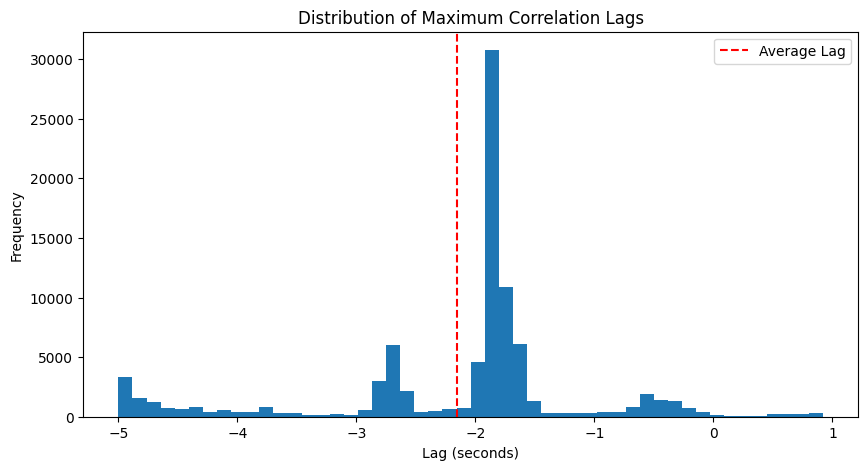

Average maximum correlation lag: -2.154298 seconds
Standard deviation of lags: 1.110671 seconds


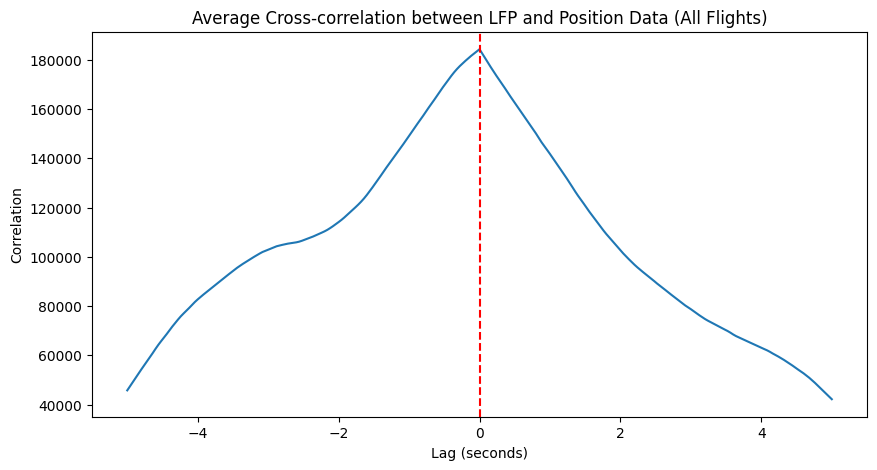

In [41]:
from bat.synchrony import test_synchronization

# Example usage
test_synchronization(flightID,tLFP)

##### Distribution of Maximum Correlation Lags

This histogram shows the distribution of time lags at which the maximum correlation occurs between Local Field Potential (LFP) activity and bat position data across all flights, channels, and spatial dimensions.

Key observations:
1. The x-axis shows lags from -5 to 1 seconds, an appropriate range for neural data analysis.
2. A prominent peak occurs at approximately -2 seconds, indicating that LFP activity often precedes position changes by this interval.
3. Smaller peaks are visible at around -3 and -5 seconds, suggesting multiple timescales of correlation.
4. The average lag (red dashed line) is slightly negative, confirming that LFP activity generally precedes position changes.

Interpretation:
- This distribution suggests that neural activity in the recorded brain areas typically precedes changes in the bat's position by about 2 seconds.
- The presence of multiple peaks indicates that different aspects of neural activity might relate to movement at various time scales, possibly reflecting different stages of motor planning and execution.
- The predominantly negative lags support the idea that the recorded brain areas are involved in movement planning and initiation processes.


This histogram shows the distribution of time lags at which the maximum correlation occurs between Local Field Potential (LFP) activity and bat position data across all flights, channels, and spatial dimensions.

Key observations:
1. The x-axis shows lags from -5 to 1 seconds, an appropriate range for neural data analysis.
2. A prominent peak occurs at approximately -2 seconds, indicating that LFP activity often precedes position changes by this interval.
3. Smaller peaks are visible at around -3 and -5 seconds, suggesting multiple timescales of correlation.
4. The average lag (red dashed line) is slightly negative, confirming that LFP activity generally precedes position changes.

Interpretation:
- This distribution suggests that neural activity in the recorded brain areas typically precedes changes in the bat's position by about 2 seconds.
- The presence of multiple peaks indicates that different aspects of neural activity might relate to movement at various time scales, possibly reflecting different stages of motor planning and execution.
- The predominantly negative lags support the idea that the recorded brain areas are involved in movement planning and initiation processes.

##### Average Cross-correlation between LFP and Position Data (All Flights)

This graph shows the average cross-correlation between LFP activity and position data across all recorded bat flights, plotted against different time lags.

Key observations:
1. The x-axis displays lags from -5 to 5 seconds, providing a symmetrical view around zero lag.
2. The peak of the correlation occurs slightly before 0 (between -0.5 and -1 seconds), consistent with the histogram above.
3. The correlation function is asymmetric, with a steeper rise before the peak and a more gradual decline after.

Interpretation:
- The negative lag of the peak correlation confirms that LFP activity in the recorded brain areas generally precedes changes in the bat's position.
- The broad peak in the cross-correlation indicates that the relationship between LFP and position is not instantaneous but extends over several seconds, reflecting ongoing processes of movement control and spatial navigation.
- The asymmetry in the cross-correlation function suggests that neural activity leading up to movement might be more tightly coupled to position changes than the activity following movement.
- These results provide strong evidence that the recorded brain areas are involved in movement planning and execution, with neural activity changes preceding observable position changes by approximately 1-2 seconds on average.

In [33]:
flightLFP = tLFP

/var/folders/zx/1lpjp2mx28scvgwy0hybb3g00000gn/T/ipykernel_37445/1848433092.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  num_flights = int(np.max(flightLFP[:, 0]))


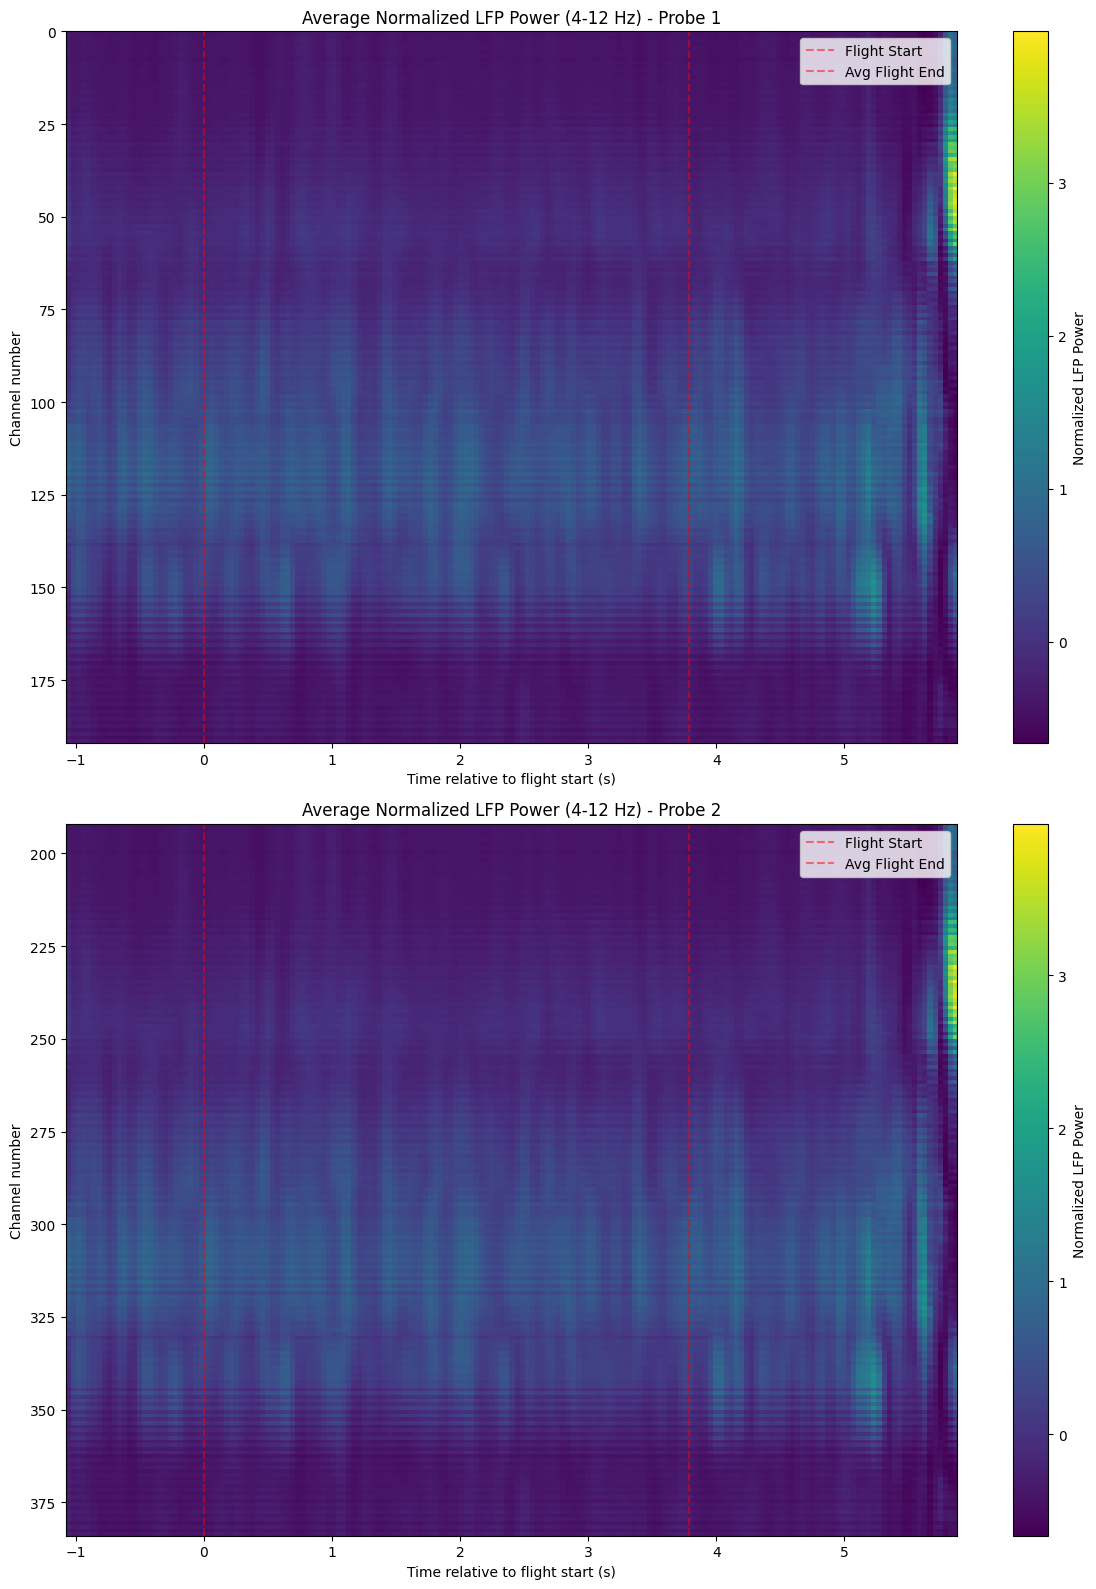

In [38]:
import numpy as np
import matplotlib.pyplot as plt
# Parameters
sampling_rate = 25  # Hz
freq_band = [4, 12]  # Hz, for labeling purposes only
num_channels = flightLFP.shape[1] - 2  # Subtract flight number and phase columns
# Create arrays to store power and flight durations
num_flights = int(np.max(flightLFP[:, 0]))
max_pre_flight = 0
max_in_flight = 0
max_post_flight = 0
# First pass to determine max durations
for flight_num in range(1, num_flights + 1):
    flight_mask = flightLFP[:, 0] == flight_num
    flight_phases = flightLFP[flight_mask, 1]
    pre_flight = np.sum(flight_phases == 0)
    in_flight = np.sum(flight_phases == 1)
    post_flight = np.sum(flight_phases == 2)

    max_pre_flight = max(max_pre_flight, pre_flight)
    max_in_flight = max(max_in_flight, in_flight)
    max_post_flight = max(max_post_flight, post_flight)
total_duration = max_pre_flight + max_in_flight + max_post_flight
# Calculate average flight end time
avg_flight_end = np.mean([np.sum(flightLFP[flightLFP[:, 0] == i, 1] == 1) for i in range(1, num_flights + 1)]) / sampling_rate
# Create time bins
time_bins = np.arange(-max_pre_flight, total_duration - max_pre_flight) / sampling_rate
# Initialize power array
power_array = np.zeros((num_flights, total_duration, num_channels))
# Calculate power for each flight and channel
for flight_num in range(1, num_flights + 1):
    flight_mask = flightLFP[:, 0] == flight_num
    flight_data = flightLFP[flight_mask, 2:]
    flight_phases = flightLFP[flight_mask, 1]

    if len(flight_data) == 0:
        continue

    # Calculate power (magnitude squared of the Hilbert transform)
    flight_power = np.abs(flight_data)**2

    # Align and store the power data
    pre_flight = np.sum(flight_phases == 0)
    in_flight = np.sum(flight_phases == 1)

    start_pad = max_pre_flight - pre_flight
    end_pad = total_duration - (start_pad + len(flight_power))

    padded_power = np.pad(flight_power, ((start_pad, end_pad), (0, 0)), mode='constant', constant_values=np.nan)

    power_array[flight_num-1] = padded_power
# Normalize power for each flight
normalized_power = (power_array - np.nanmean(power_array, axis=(1,2), keepdims=True)) / np.nanstd(power_array, axis=(1,2), keepdims=True)
# Average power across all flights
avg_power = np.nanmean(normalized_power, axis=0)
# Assuming two probes with equal number of channels
channels_per_probe = num_channels // 2
# Create subplots for each probe
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
# Plot for Probe 1
im1 = ax1.imshow(avg_power[:, :channels_per_probe].T, aspect='auto', cmap='viridis', 
                 extent=[time_bins[0], time_bins[-1], channels_per_probe, 0])
ax1.set_title(f'Average Normalized LFP Power ({freq_band[0]}-{freq_band[1]} Hz) - Probe 1')
ax1.set_xlabel('Time relative to flight start (s)')
ax1.set_ylabel('Channel number')
plt.colorbar(im1, ax=ax1, label='Normalized LFP Power')
# Plot for Probe 2
im2 = ax2.imshow(avg_power[:, channels_per_probe:].T, aspect='auto', cmap='viridis', 
                 extent=[time_bins[0], time_bins[-1], num_channels, channels_per_probe])
ax2.set_title(f'Average Normalized LFP Power ({freq_band[0]}-{freq_band[1]} Hz) - Probe 2')
ax2.set_xlabel('Time relative to flight start (s)')
ax2.set_ylabel('Channel number')
plt.colorbar(im2, ax=ax2, label='Normalized LFP Power')
# Add vertical lines to mark average flight start and end on both plots
for ax in [ax1, ax2]:
    ax.axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Flight Start')
    ax.axvline(x=avg_flight_end, color='r', linestyle='--', alpha=0.5, label='Avg Flight End')
    ax.legend()
plt.tight_layout()
plt.show()

# Applying TIMBRE


Initial train_inds (before balancing): 305
actual_indices length: 305
unique_elements: [0. 1. 2.]
elements_indices: {0.0: [6981, 6982, 6983, 6984, 6985, 7095, 7096, 7097, 7098, 7099, 7208, 7209, 7210, 7211, 7212, 7324, 7325, 7326, 7327, 7328, 7552, 7553, 7554, 7555, 7556, 7663, 7664, 7665, 7666, 7667, 11234, 11235, 11236, 11237, 11238, 11352, 11353, 11354, 11355, 11356], 1.0: [303, 304, 305, 306, 307, 458, 459, 460, 461, 462, 616, 617, 618, 619, 620, 772, 773, 774, 775, 776, 1090, 1091, 1092, 1093, 1094, 1255, 1256, 1257, 1258, 1259, 1412, 1413, 1414, 1415, 1416, 1570, 1571, 1572, 1573, 1574, 1881, 1882, 1883, 1884, 1885, 2038, 2039, 2040, 2041, 2042, 2187, 2188, 2189, 2190, 2191, 2350, 2351, 2352, 2353, 2354, 2661, 2662, 2663, 2664, 2665, 2818, 2819, 2820, 2821, 2822, 2973, 2974, 2975, 2976, 2977, 3129, 3130, 3131, 3132, 3133, 3441, 3442, 3443, 3444, 3445, 3596, 3597, 3598, 3599, 3600, 3751, 3752, 3753, 3754, 3755, 3907, 3908, 3909, 3910, 3911, 4225, 4226, 4227, 4228, 4229, 4384, 4385

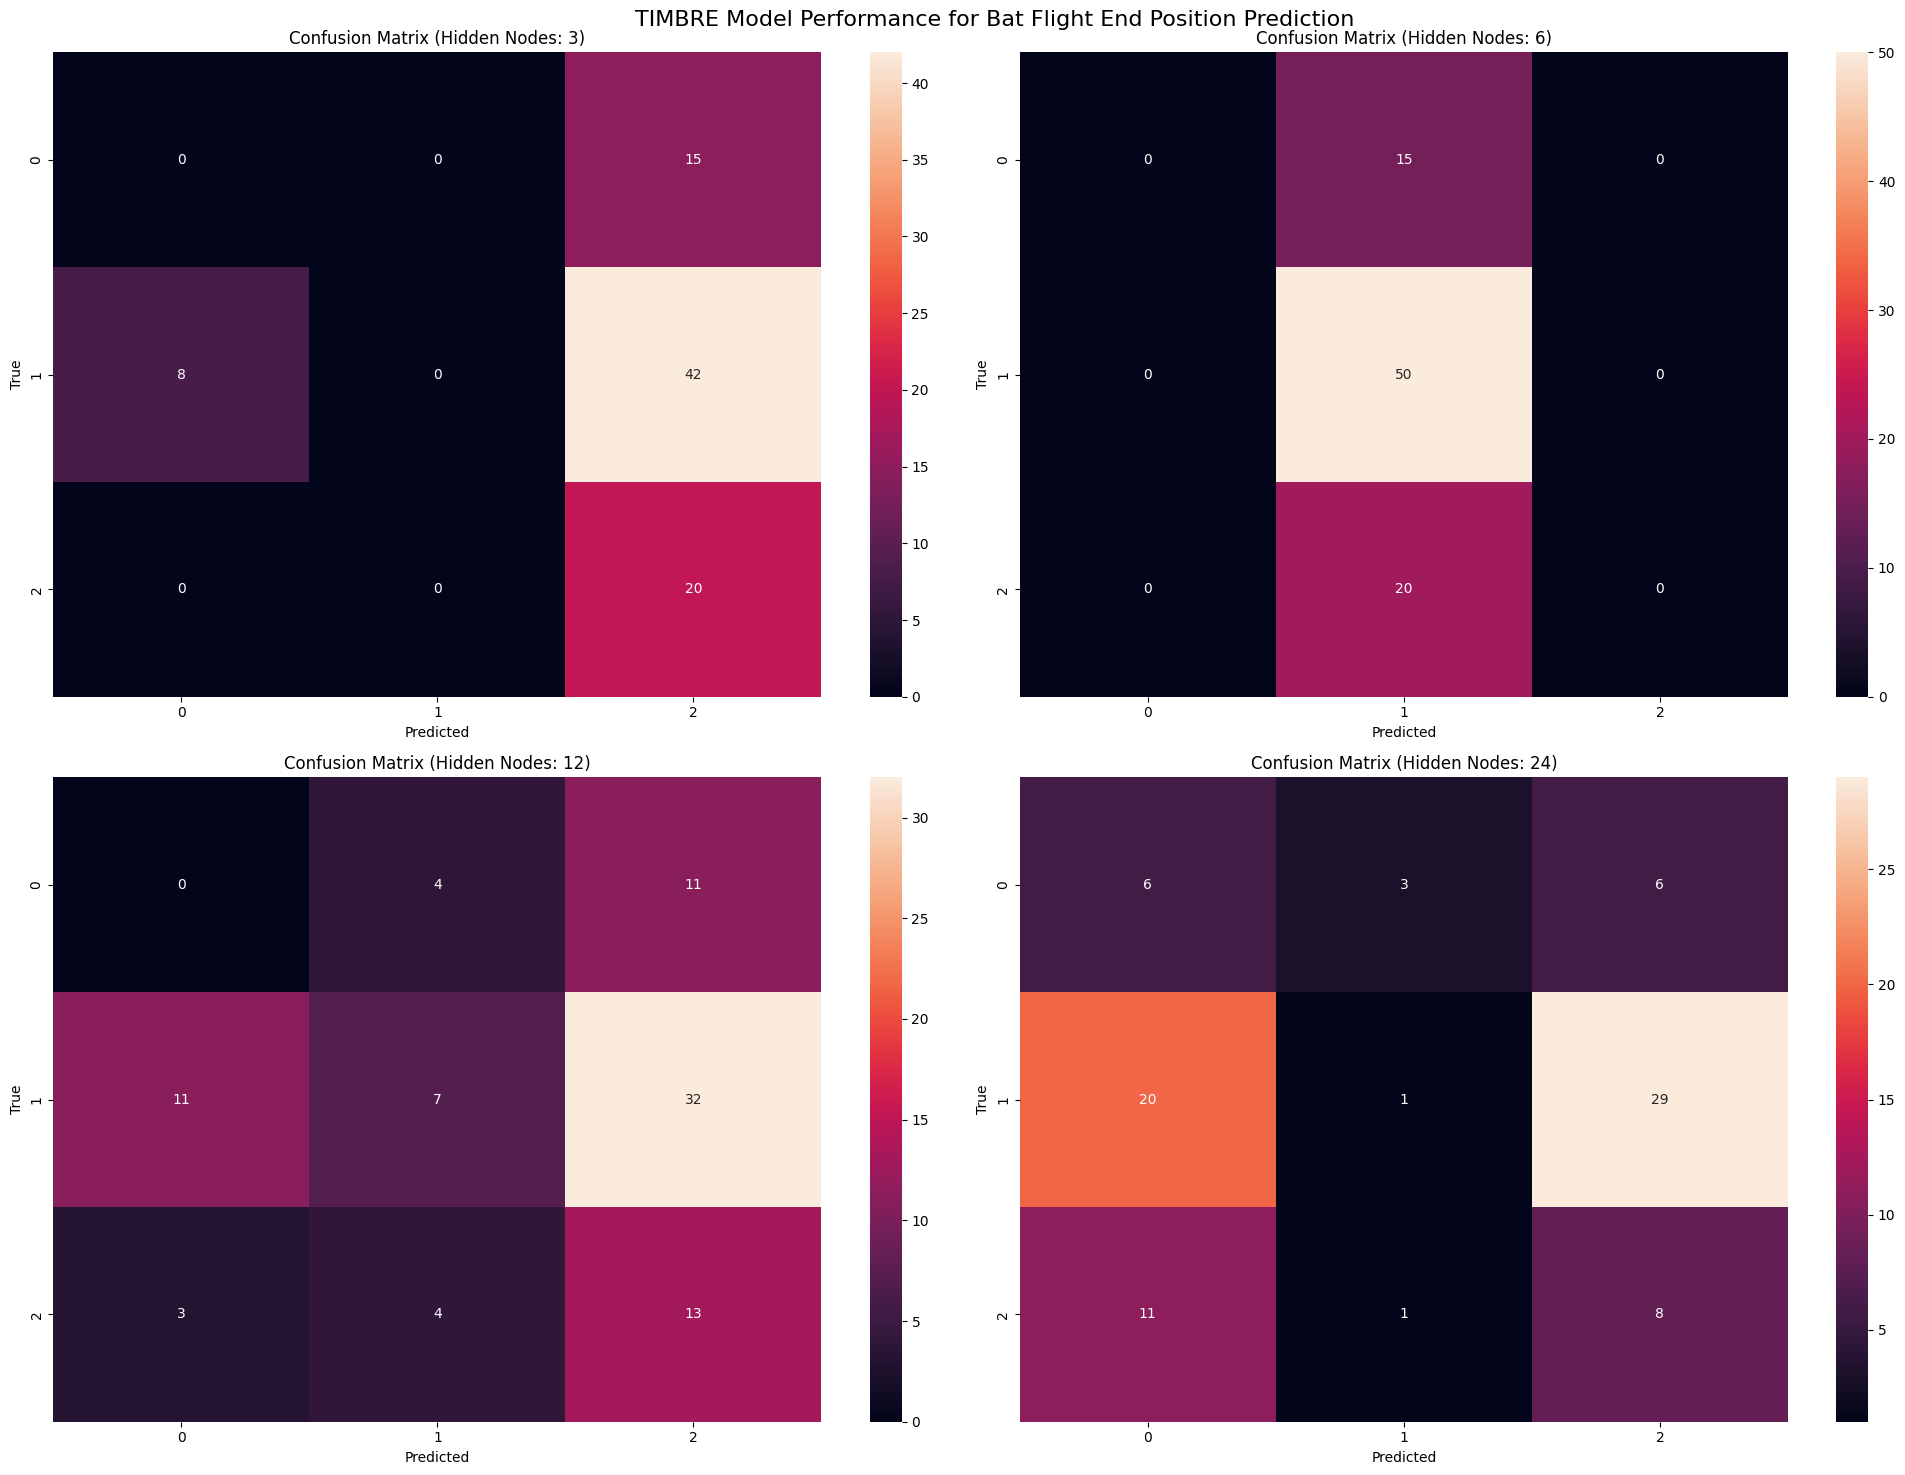

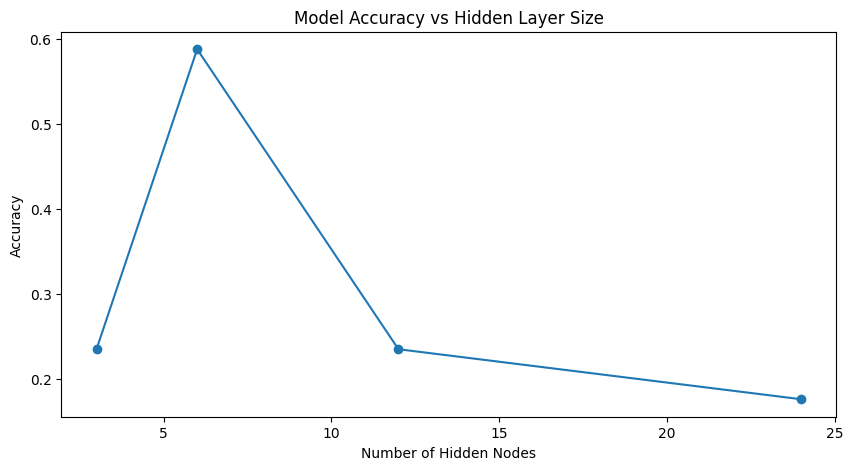

In [35]:
from matplotlib import pyplot as plt
from TIMBRE import TIMBRE
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('TIMBRE Model Performance for Bat Flight End Position Prediction', fontsize=16)

n_folds = 5
which_fold = 0

test_inds, train_inds = test_train_bat(flightID, n_folds, which_fold)
wLFPs, _, _ = helpers.whiten(tLFP, train_inds)

accuracies = []
hidden_sizes = [3, 6, 12, 24]

for i, hidden_size in enumerate(hidden_sizes):
    print(f"Training network with {hidden_size} hidden nodes")
    m, _, _ = TIMBRE(wLFPs, flightID[:, 1], test_inds, train_inds, hidden_nodes=hidden_size, is_categorical=True)
    
    # Get predictions
    output_layer = helpers.layer_output(wLFPs[test_inds], m, -1)
    predictions = np.argmax(output_layer, axis=1)
    true_labels = flightID[test_inds, 1]
    
    # Calculate accuracy
    accuracy = np.mean(predictions == true_labels)
    accuracies.append(accuracy)
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(f'Confusion Matrix (Hidden Nodes: {hidden_size})')
    axs[i//2, i%2].set_xlabel('Predicted')
    axs[i//2, i%2].set_ylabel('True')

plt.tight_layout()
plt.show()

# Plot accuracy vs model complexity
plt.figure(figsize=(10, 5))
plt.plot(hidden_sizes, accuracies, marker='o')
plt.title('Model Accuracy vs Hidden Layer Size')
plt.xlabel('Number of Hidden Nodes')
plt.ylabel('Accuracy')
plt.show()

In [36]:
def group_by_pos_bat(positions, n_bins, train_inds):
    min_pos = np.min(positions[train_inds], axis=0)
    max_pos = np.max(positions[train_inds], axis=0)
    return np.floor((positions - min_pos) / (max_pos - min_pos) * n_bins).astype(int)

Initial train_inds (before balancing): 305
actual_indices length: 305
unique_elements: [0. 1. 2.]
elements_indices: {0.0: [6981, 6982, 6983, 6984, 6985, 7095, 7096, 7097, 7098, 7099, 7208, 7209, 7210, 7211, 7212, 7324, 7325, 7326, 7327, 7328, 7552, 7553, 7554, 7555, 7556, 7663, 7664, 7665, 7666, 7667, 11234, 11235, 11236, 11237, 11238, 11352, 11353, 11354, 11355, 11356], 1.0: [303, 304, 305, 306, 307, 458, 459, 460, 461, 462, 616, 617, 618, 619, 620, 772, 773, 774, 775, 776, 1090, 1091, 1092, 1093, 1094, 1255, 1256, 1257, 1258, 1259, 1412, 1413, 1414, 1415, 1416, 1570, 1571, 1572, 1573, 1574, 1881, 1882, 1883, 1884, 1885, 2038, 2039, 2040, 2041, 2042, 2187, 2188, 2189, 2190, 2191, 2350, 2351, 2352, 2353, 2354, 2661, 2662, 2663, 2664, 2665, 2818, 2819, 2820, 2821, 2822, 2973, 2974, 2975, 2976, 2977, 3129, 3130, 3131, 3132, 3133, 3441, 3442, 3443, 3444, 3445, 3596, 3597, 3598, 3599, 3600, 3751, 3752, 3753, 3754, 3755, 3907, 3908, 3909, 3910, 3911, 4225, 4226, 4227, 4228, 4229, 4384, 4385

NameError: name 'arm_and_pos_binned' is not defined

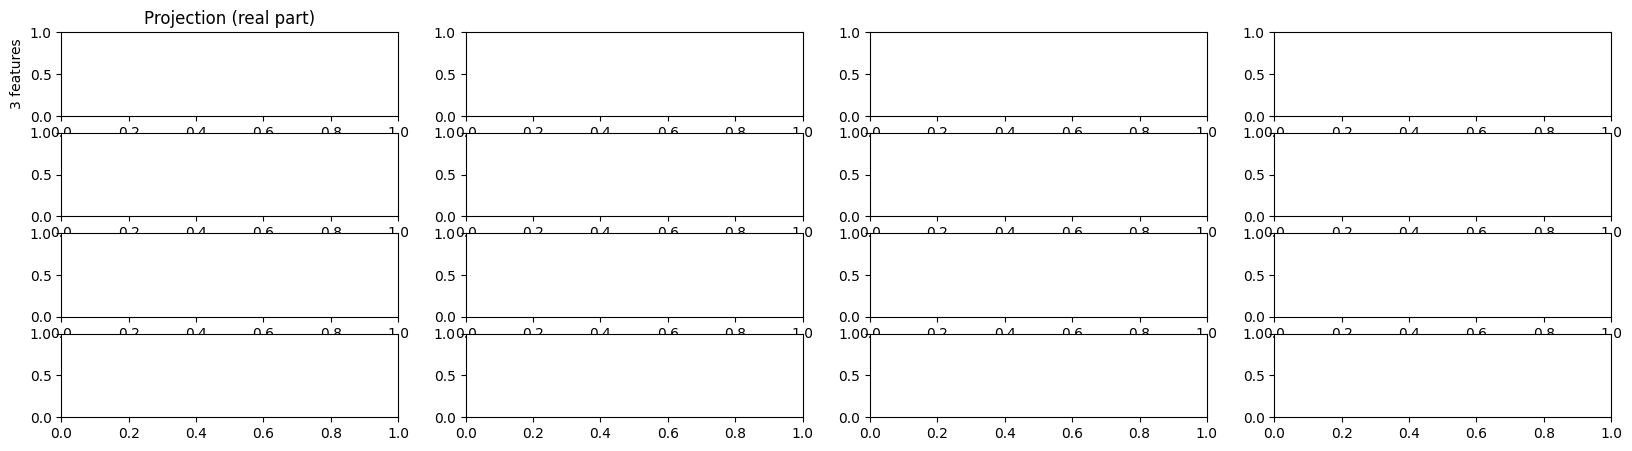

In [37]:
from matplotlib import pyplot as plt
import numpy as np
import rat.helpers as helpers
from TIMBRE import TIMBRE  # Make sure this import works with your file structure

fig, axs = plt.subplots(4, 4, figsize=(20, 5))

n_folds = 5
which_fold = 0

test_inds, train_inds = test_train_bat(flightID, n_folds, which_fold)
wLFPs, _, _ = helpers.whiten(tLFP, train_inds)

# Use only X and Y positions as targets
target = flightID[:, 2:4]  # X, Y positions

n_bins = 10
pos_binned = group_by_pos_bat(flightID[:, 2:4], n_bins, train_inds)
pos_flattened = pos_binned[:, 0] * n_bins + pos_binned[:, 1]

titles = ['Projection (real part)', 'Amplitude', 'Softmax 1', 'Softmax 2 (Output)'];
for i in range(axs.shape[0]):
    print(f"Training network {i + 1} of {axs.shape[0]} (hidden layer size {3 * 2 ** i})")  # try 4 different hidden layer sizes
    m, _, _ = TIMBRE(wLFPs, flightID[:,1], test_inds, train_inds, hidden_nodes=3 * 2 ** i)  # train network
    for j in range(axs.shape[1]):  # Loop through each layer
        p = helpers.layer_output(wLFPs[test_inds], m, j)  # Calculate layer's response to input, using only test data
        if j == 0:
            p = p[:, :p.shape[1] // 2]  # just get real component for complex-valued output
            axs[i, 0].set_ylabel(str(3 * 2 ** i) + ' features');
        if i == 0:
            axs[0, j].set_title((titles[j]));
        axs[i, j].plot(helpers.accumarray(arm_and_pos_binned[test_inds], p));  # plot mean response of layer to test data as a function of position
        axs[i, j].autoscale(enable=True, axis='both', tight=True);
        if i < axs.shape[0] - 1:
            axs[i, j].set_xticks([]);
        else:
            axs[i, j].set_xlabel('Position');
